### Measure step length from depth image

In [1]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt

import modules.images as im

In [2]:
load_dir = os.path.join(os.path.sep, 'Users', 'andrewhynes', 'MEGA', 'Data',\
                        'Czarnuch images', 'Depth data', '14-12-16_trial-004_depth16bit')

In [3]:
file_paths = glob.glob(os.path.join(load_dir, '*.png'))

In [4]:
%matplotlib inline


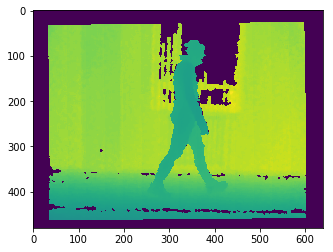

In [5]:
file_path = file_paths[246]

# Depth image (depth in mm)
img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)

# Convert to cm
img = img / 10

plt.imshow(img)
plt.show()


In [205]:
x_res, y_res = 640, 480

f_xz = 1.11146664619446
f_yz = 0.833599984645844

f_xz_new = 1.122133  
f_yz_new =  0.84176


f_xz = f_xz_new
f_yz = f_yz_new


In [206]:
x_1, y_1 = 275, 400
x_2, y_2 = 405, 390



z_1, z_2 = img[y_1, x_1], img[y_2, x_2]

point_1 = np.array([x_1, y_1, z_1])
point_2 = np.array([x_2, y_2, z_2])

In [207]:
point_real_1 = im.proj_to_real(point_1, x_res, y_res, f_xz, f_yz)
point_real_2 = im.proj_to_real(point_2, x_res, y_res, f_xz, f_yz)

In [208]:
point_real_1

array([-19.83545411, -70.539488  , 251.4       ])

In [209]:
point_real_2

array([ 39.18085169, -69.155845  , 262.9       ])

In [210]:
np.linalg.norm(point_real_1 - point_real_2)

60.142238223291955